In [1]:
#%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.ticker import FormatStrFormatter
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import texttable
import gc
import timeit
import sys
import os

# Loading reported and synthetic data

In [3]:
# Revoking stored reported data
# https://ipython.org/ipython-doc/rel-0.12/config/extensions/storemagic.html

%store -r data_Averoy
%store -r data_Tingvoll
%store -r data_Surnadal
%store -r data_Sunndal
%store -r data_Vestnes
%store -r data_Laerdal

In [4]:
# Revoking top hits frames
save_dir = "synthetic_data/"
# With option for emigration
top_hits_Averoy_seen_deer = pd.read_pickle(
    save_dir + "top_hits_Averoy_seen_deer_stoch_par.pkl"
)
top_hits_Tingvoll_seen_deer = pd.read_pickle(
    save_dir + "top_hits_Tingvoll_seen_deer_stoch_par.pkl"
)
top_hits_Surnadal_seen_deer = pd.read_pickle(
    save_dir + "top_hits_Surnadal_seen_deer_stoch_par.pkl"
)
top_hits_Sunndal_seen_deer = pd.read_pickle(
    save_dir + "top_hits_Sunndal_seen_deer_stoch_par.pkl"
)
top_hits_Vestnes_seen_deer = pd.read_pickle(
    save_dir + "top_hits_Vestnes_seen_deer_stoch_par.pkl"
)
top_hits_Laerdal_seen_deer = pd.read_pickle(
    save_dir + "top_hits_Laerdal_seen_deer_stoch_par.pkl"
)

In [5]:
# Data needed for plotting the figures below
municipalities = ["Averoy", "Tingvoll", "Surnadal", "Sunndal", "Vestnes", "Laerdal"]
data_municipality = [
    data_Averoy,
    data_Tingvoll,
    data_Surnadal,
    data_Sunndal,
    data_Vestnes,
    data_Laerdal,
]
top_hits_seen_deer = [
    top_hits_Averoy_seen_deer,
    top_hits_Tingvoll_seen_deer,
    top_hits_Surnadal_seen_deer,
    top_hits_Sunndal_seen_deer,
    top_hits_Vestnes_seen_deer,
    top_hits_Laerdal_seen_deer,
]

afont = {"fontname": "Arial"}

## Left panels: The best synthetic data hit against the seen deer per hour data

In [6]:
def plot_comp_seen_deer(municipalities, data_municipality, ax):

    for location in municipalities:
        if location == "Averoy":
            q = 0
        if location == "Tingvoll":
            q = 1
        if location == "Surnadal":
            q = 2
        if location == "Sunndal":
            q = 3
        if location == "Vestnes":
            q = 4
        if location == "Laerdal":
            q = 5

        [
            municipality,
            first_year,
            last_year,
            number_of_years,
            years,
            seen_deer_obs,
            seen_deer_obs_forest,
            seen_deer_obs_farmland,
            hinds_per_stag_obs,
            total_harvest,
            total_quota,
            fraction_female_calves_harvested,
            fraction_young_hinds_harvested,
            fraction_adult_hinds_harvested,
            fraction_male_calves_harvested,
            fraction_young_stags_harvested,
            fraction_adult_stags_harvested,
            spring_counts,
        ] = data_municipality[q]

        if location == "Surnadal":
            seen_deer_e = np.array(seen_deer_obs_farmland)
        else:
            seen_deer_e = np.array(seen_deer_obs)

        # Extract predicted array associated with the top hit
        seen_deer_p = np.array(
            top_hits_seen_deer[q][0:number_of_years]['tot_pop_bh'].tolist()
        )

        # Scale the prediction array
        scaling_factor = top_hits_seen_deer[q].iloc[0]["scaling"]
        seen_deer_p_scaled = scaling_factor * seen_deer_p

        # Make dotplot
        year_list = np.arange(number_of_years)
        ax[q].plot(year_list, seen_deer_p_scaled, "bo", markersize=6)

        formatter = ticker.FormatStrFormatter("%.2f")
        ax[q].yaxis.set_major_formatter(formatter)
        no_text = [""] * number_of_years
        if q < 5:
            ax[q].set_xticks(year_list)
            ax[q].set_xticklabels(no_text)
        else:
            ax[q].set_xticks(year_list)
            ax[q].set_xticklabels(years, rotation="vertical")

        ax[q].set_ylabel(municipality + " (seen_deer h$^{-1}$)", fontsize=12, **afont)
        ax[q].plot(year_list, seen_deer_e, "ro", markersize=6)

        # ax[q].margins(x=0.0)
        ymin = [0.5, 0.4, 0.5, 0.2, 0.3, 0.2]
        ymax = [1.8, 0.7, 1.5, 0.6, 0.8, 0.4]
        ax[q].set_ylim([ymin[q], ymax[q]])

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

## Panels in the middle: Boxplots of the variation in key population parameters for the # top hits

In [7]:
def plot_parameters_seen_deer(
    municipalities, data_municipality, top_hits_seen_deer, ax
):
    # Just for fitting the y-axis
    y_min = [0, 0, 0, 0, 0, 0]
    y_max = [2, 3.5, 2.5, 2.5, 3.0, 2.5]

    for location in municipalities:
        if location == "Averoy":
            q = 0
        if location == "Tingvoll":
            q = 1
        if location == "Surnadal":
            q = 2
        if location == "Sunndal":
            q = 3
        if location == "Vestnes":
            q = 4
        if location == "Laerdal":
            q = 5

        [
            municipality,
            first_year,
            last_year,
            number_of_years,
            years,
            seen_deer_obs,
            seen_deer_obs_forest,
            seen_deer_obs_farmland,
            hinds_per_stag_obs,
            total_harvest,
            total_quota,
            fraction_female_calves_harvested,
            fraction_young_hinds_harvested,
            fraction_adult_hinds_harvested,
            fraction_male_calves_harvested,
            fraction_young_stags_harvested,
            fraction_adult_stags_harvested,
            spring_counts,
        ] = data_municipality[q]

        # Extract last year record data
        top_20_sh_ = top_hits_seen_deer[q][0 : 20 * number_of_years][
            "sh_threshold"
        ].values
        top_20_sh = top_20_sh_[number_of_years - 1 :: number_of_years]

        top_100_sh_ = top_hits_seen_deer[q][0 : 100 * number_of_years][
            "sh_threshold"
        ].values
        top_100_sh = top_100_sh_[number_of_years - 1 :: number_of_years]

        top_1000_sh_ = top_hits_seen_deer[q][0 : 1000 * number_of_years][
            "sh_threshold"
        ].values
        top_1000_sh = top_1000_sh_[number_of_years - 1 :: number_of_years]

        top_20_init_ = top_hits_seen_deer[q][0 : 20 * number_of_years][
            "init_pop"
        ].values
        top_20_init = top_20_init_[number_of_years - 1 :: number_of_years]

        top_100_init_ = top_hits_seen_deer[q][0 : 100 * number_of_years][
            "init_pop"
        ].values
        top_100_init = top_100_init_[number_of_years - 1 :: number_of_years]

        top_1000_init_ = top_hits_seen_deer[q][0 : 1000 * number_of_years][
            "init_pop"
        ].values
        top_1000_init = top_1000_init_[number_of_years - 1 :: number_of_years]

        top_20_end_ = top_hits_seen_deer[q][0 : 20 * number_of_years][
            "tot_pop_ah"
        ].values
        top_20_end = top_20_end_[number_of_years - 1 :: number_of_years]

        top_100_end_ = top_hits_seen_deer[q][0 : 100 * number_of_years][
            "tot_pop_ah"
        ].values
        top_100_end = top_100_end_[number_of_years - 1 :: number_of_years]

        top_1000_end_ = top_hits_seen_deer[q][0 : 1000 * number_of_years][
            "tot_pop_ah"
        ].values
        top_1000_end = top_1000_end_[number_of_years - 1 :: number_of_years]

        data_collected = [
            top_20_sh,
            top_100_sh,
            top_1000_sh,
            top_20_init / 1000.0,
            top_100_init / 1000.0,
            top_1000_init / 1000.0,
            top_20_end / 1000.0,
            top_100_end / 1000.0,
            top_1000_end / 1000.0,
        ]
        if q == 1:
            print(np.median(top_1000_end))

        x_pos = [1, 2, 3, 4, 5, 6, 7, 8, 9]
        width = [0.3] * 9
        ax[q].set_xticks(x_pos)

        from matplotlib.ticker import FormatStrFormatter

        ax[q].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

        if q == 5:
            labels = [
                "stags_per_hind_t_20",
                "stags_per_hind_t_100",
                "stags_per_hind_t_1000",
                "pop_2006_20/1000",
                "pop_2006_100/1000",
                "pop_2006_1000/1000",
                "pop_2023_20/1000",
                "pop_2023_100/1000",
                "pop_2023_1000/1000",
            ]
            ax[q].set_xticklabels(labels, rotation="vertical", fontsize=8)
        else:
            labels = ["", "", "", "", "", "", "", "", ""]

        ax[q].yaxis.set_major_locator(ticker.AutoLocator())
        ax[q].yaxis.set_minor_locator(ticker.AutoMinorLocator())

        ax[q].set_ylabel(municipality, fontsize=12, **afont)

        box = ax[q].boxplot(
            data_collected, showfliers=False, labels=labels, patch_artist=True
        )

        colors = [
            "steelblue",
            "steelblue",
            "steelblue",
            "firebrick",
            "firebrick",
            "firebrick",
            "darkslategray",
            "darkslategray",
            "darkslategray",
        ]

        for patch, color in zip(box["boxes"], colors):
            patch.set_facecolor(color)

        ax[q].margins(x=0.0)
        ymin = y_min[q]
        ymax = y_max[q]
        ax[q].set_ylim([ymin, ymax])
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

## Right panels: Mean migration percentage in the period 2007-2023 for the top # hits

In [8]:
def plot_emigration_seen_deer(
    municipalities, data_municipality, top_hits_seen_deer, ax
):
    """
    Plots mean emigration percentage for each year over all # top_hits against
    seen deer per hour.
    """

    for location in municipalities:
        if location == "Averoy":
            q = 0
        if location == "Tingvoll":
            q = 1
        if location == "Surnadal":
            q = 2
        if location == "Sunndal":
            q = 3
        if location == "Vestnes":
            q = 4
        if location == "Laerdal":
            q = 5

        [
            municipality,
            first_year,
            last_year,
            number_of_years,
            years,
            seen_deer_obs,
            seen_deer_obs_forest,
            seen_deer_obs_farmland,
            hinds_per_stag_obs,
            total_harvest,
            total_quota,
            fraction_female_calves_harvested,
            fraction_young_hinds_harvested,
            fraction_adult_hinds_harvested,
            fraction_male_calves_harvested,
            fraction_young_stags_harvested,
            fraction_adult_stags_harvested,
            spring_counts,
        ] = data_municipality[q]

        # Extract migration data for 20 tophits
        top_20_mig_ = top_hits_seen_deer[q][0 : 20 * number_of_years]["mig%"].values
        mig_percentage = np.zeros((20, number_of_years))
        for i in range(1, 21):
            # for j in range(number_of_years):
            mig_percentage[i - 1, 0:number_of_years] = top_20_mig_[
                (i - 1) * number_of_years : i * number_of_years
            ]

        # Make boxplot
        # Define positions as an array within call to align with the xtick-labeling below
        ax[q].boxplot(
            mig_percentage,
            positions=np.arange(number_of_years),
            showfliers=False,
        )

        formatter = ticker.FormatStrFormatter("%.1f")
        ax[q].yaxis.set_major_formatter(formatter)
        year_list = np.arange(number_of_years)
        no_text = [""] * number_of_years

        if q < 5:
            ax[q].set_xticks(year_list)
            ax[q].set_xticklabels(no_text)
        else:
            ax[q].set_xticks(year_list)
            ax[q].set_xticklabels(years, rotation="vertical")

        ax[q].set_ylabel(municipality + " (s_emig_%)", fontsize=12, **afont)
        ymin = 0
        ymax = 40
        ax[q].set_ylim([ymin, ymax])

    fig.tight_layout()
    fig.subplots_adjust(top=0.96)

## Plotting and saving figure

2060.5
CPU times: user 4.81 s, sys: 266 ms, total: 5.08 s
Wall time: 4.23 s


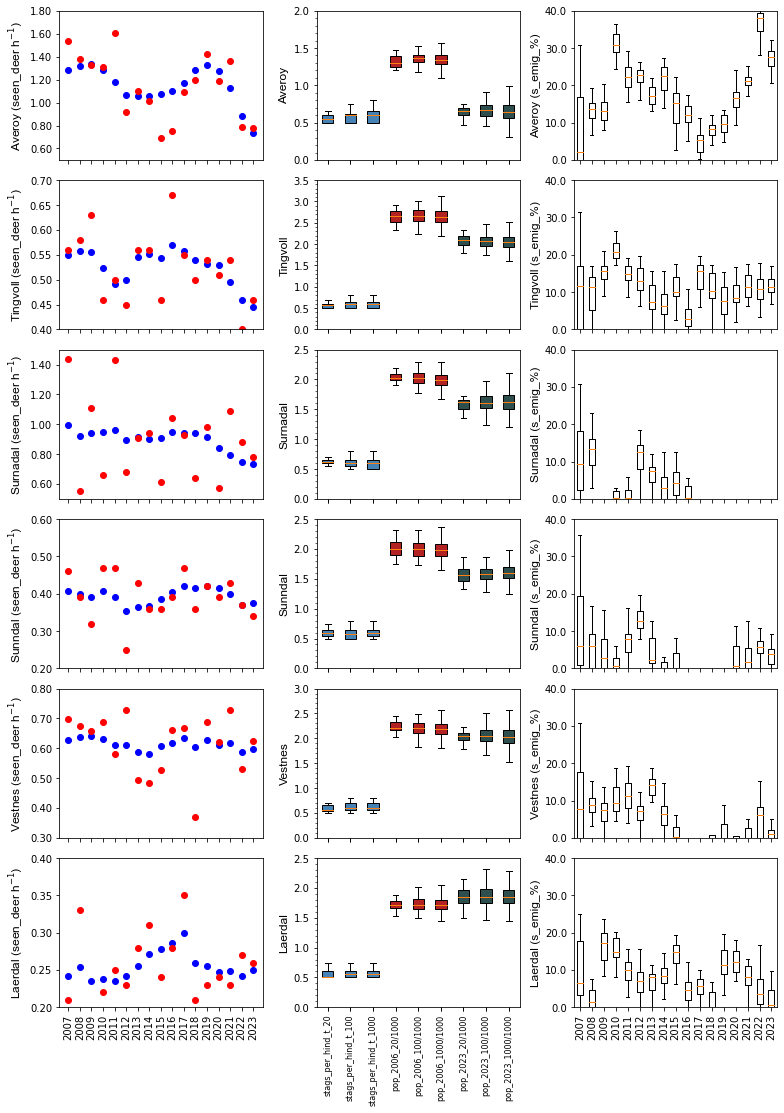

In [9]:
%%time
municipalities = ["Averoy", "Tingvoll", "Surnadal", "Sunndal", "Vestnes", "Laerdal"]
data_municipality = [
    data_Averoy,
    data_Tingvoll,
    data_Surnadal,
    data_Sunndal,
    data_Vestnes,
    data_Laerdal,
]

fig, axs = plt.subplots(ncols=3, nrows=6, figsize=(11, 16))
ax1 = [axs[0, 0], axs[1, 0], axs[2, 0], axs[3, 0], axs[4, 0], axs[5, 0]]
ax2 = [axs[0, 1], axs[1, 1], axs[2, 1], axs[3, 1], axs[4, 1], axs[5, 1]]
ax3 = [axs[0, 2], axs[1, 2], axs[2, 2], axs[3, 2], axs[4, 2], axs[5, 2]]

plot_comp_seen_deer(municipalities, data_municipality, ax1)
plot_parameters_seen_deer(municipalities, data_municipality, top_hits_seen_deer, ax2)
plot_emigration_seen_deer(municipalities, data_municipality, top_hits_seen_deer, ax3)
save_dir = "figures/"
plt.savefig(save_dir + "Figure_3.pdf", dpi=600, bbox_inches="tight")